## Tom's work starts here.

### Gather dependencies

In [1]:
# Dependencies
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
# from sodapy import Socrata
from config import census_key
import pprint
import requests
import csv
import os
import scipy.stats as st
from scipy.stats import linregress

### Function for quickly calling a DataFrame

In [2]:
# Function for quickly assempling a DataFrame
def json_to_dataframe(response):
    return pd.DataFrame(response.json()[1:], columns=response.json()[0])

### Create DataFrame for CDC Data

In [3]:
cdc_data = pd.read_csv("../Project_1/cdc_data.csv")
cdc_data
cdc_df = pd.DataFrame(cdc_data)
cdc_df

# Choose the columns we want and rename anything that isn't clear
cdc_df = cdc_df[['case_month', 'res_state', 'res_county', 'age_group', 'sex', 'race', 'ethnicity', 'current_status']]
cdc_df = cdc_df.rename(columns={
    'res_state': 'State',
    'res_county': 'County',
    'ethnicity': 'Ethnicity',
    'current_status': 'Infection Status',
    'race':'Race'
})

# Drop "Unkown" race from dataset
cdc_df = cdc_df.loc[cdc_df['Race']!= 'Unknown', :]

# Set Infections to 1 and replace the various races with values that are compatible with the census data
cdc_df['Infections'] = 1
cdc_df['Race'] = cdc_df['Race'].replace('White', 'Caucasian')
cdc_df['Race'] = cdc_df['Race'].replace('Black', 'African American')
cdc_df['Race'] = cdc_df['Race'].replace('American Indian/Alaska Native', 'Native American')
cdc_df['Race'] = cdc_df['Race'].replace('Multiple/Other', 'Other')
cdc_df['Race'] = np.where(np.logical_and(cdc_df['Race'] == 'Caucasian', cdc_df['Ethnicity'] == 'Hispanic/Latino'), 'Hispanic', cdc_df['Race'])

# NOTE: It's not clear what happens with Hawaiian here. 

cdc_df.head()

,case_month,State,County,age_group,sex,Race,Ethnicity,Infection Status,Infections
0,2021-11,MN,STEELE,18 to 49 years,Male,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1
2,2021-11,MN,STEARNS,50 to 64 years,Female,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1
3,2020-05,MN,KANDIYOHI,18 to 49 years,Male,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1
4,2021-05,MN,ANOKA,18 to 49 years,Male,NaN,NaN,Laboratory-confirmed case,1
5,2020-04,MN,CLAY,65+ years,Female,Caucasian,Non-Hispanic/Latino,Laboratory-confirmed case,1


### Drop NaN and compile totals by county and race

In [4]:
# Drop NaNs and then group by County and Race
cdc_df = cdc_df.dropna(how='any')
cdc_df = cdc_df[['County', 'Race', 'Infections']]
cdc_grouped_county = cdc_df.groupby(['County', 'Race'])
cdc_df = cdc_grouped_county.count()
cdc_df.reset_index(inplace=True)
cdc_df.head()

,County,Race,Infections
0,ANOKA,African American,2864
1,ANOKA,Asian,1732
2,ANOKA,Caucasian,24501
3,ANOKA,Hispanic,746
4,ANOKA,Native American,73


### Create poverty DataFrame based on US Census

In [5]:
# Poverty DataFrame By Race - 2020

url = "https://api.census.gov/data/2020/acs/acs5?get=NAME,B17001_002E,B17001A_002E,B17001B_002E,B17001C_002E,B17001D_002E,B17001E_002E,B17001F_002E,B17001G_002E,B17001H_002E,B17001I_002E&for=county:*&in=state:27&key={0}".format(census_key)
response = requests.request("GET", url)
response
poverty_df = json_to_dataframe(response)

# Split NAME into county & state
name = poverty_df['NAME'].str.split(",", n=1, expand=True)
COUNTY = poverty_df['County'] = name[0]
STATE = poverty_df['State'] = name[1]
poverty_df.drop(columns=["NAME"], inplace=True)
poverty_df['Caucasian2'] = poverty_df['B17001A_002E'].astype(int) - poverty_df['B17001I_002E'].astype(int)
poverty_df['Other'] = poverty_df['B17001F_002E'].astype(int) + poverty_df['B17001G_002E'].astype(int)

# Get the columns we want
poverty_df = poverty_df[['County', 'State','B17001_002E','Caucasian2', 'B17001B_002E','B17001C_002E','B17001D_002E','B17001E_002E','Other','B17001I_002E']]

# Rename columns to something intelligible
poverty_df = poverty_df.rename(columns={
    'B17001_002E':'Poverty Total',
    'Caucasian2':'Caucasian',
    'B17001B_002E':'African American',
    'B17001C_002E':'Native American',
    'B17001D_002E':'Asian',
    'B17001E_002E':'Hawaiian', # I had to change this from Native Hawaiian to Hawaiian for compatibility with the rest - Dom
    'B17001I_002E':'Hispanic' 
    })

# # Remove ...County from County in dataframe
poverty_df['County'] = poverty_df['County'].replace('County', '', regex=True)
# NOTE: The line above accidentally leaves a blank space at the end of these county names! That space caused a merge to fail
# on any of these counties because, for example, "AITKIN " is not the same as "AITKIN". 

# Remove any blank space that may be present at the begining or end of the county name
poverty_df['County'] = poverty_df['County'].str.strip()

# And then convert the county name to uppercase
poverty_df['County'] = poverty_df['County'].str.upper()

poverty_df['Year'] = 2020
#poverty_df.to_csv("../Project_1/population_in_poverty.csv")
poverty_df

,County,State,Poverty Total,Caucasian,African American,Native American,Asian,Hawaiian,Other,Hispanic,Year
0,ANOKA,Minnesota,20270,11778,3697,327,953,0,1964,1551,2020
1,BECKER,Minnesota,3588,2296,17,709,45,0,381,140,2020
2,BELTRAMI,Minnesota,8167,3657,310,3056,39,0,734,371,2020
3,BENTON,Minnesota,3357,2605,333,19,73,0,205,122,2020
4,BIG STONE,Minnesota,596,596,0,0,0,0,0,0,2020
...,...,...,...,...,...,...,...,...,...,...,...
82,RENVILLE,Minnesota,1373,717,29,97,8,0,245,277,2020
83,ROSEAU,Minnesota,1133,971,6,67,11,0,28,50,2020
84,SHERBURNE,Minnesota,4953,2857,578,171,251,0,737,359,2020
85,STEELE,Minnesota,2887,1835,426,113,3,0,149,361,2020


In [6]:
# Choose only the columns we need
poverty_df = poverty_df[['County', 'Caucasian', 'African American', 'Native American', 'Asian', 'Hawaiian', 'Other', 'Hispanic']]
poverty_df

,County,Caucasian,African American,Native American,Asian,Hawaiian,Other,Hispanic
0,ANOKA,11778,3697,327,953,0,1964,1551
1,BECKER,2296,17,709,45,0,381,140
2,BELTRAMI,3657,310,3056,39,0,734,371
3,BENTON,2605,333,19,73,0,205,122
4,BIG STONE,596,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
82,RENVILLE,717,29,97,8,0,245,277
83,ROSEAU,971,6,67,11,0,28,50
84,SHERBURNE,2857,578,171,251,0,737,359
85,STEELE,1835,426,113,3,0,149,361


In [7]:
# Use melt to convert this into a format similar to the CDC data
poverty_df = poverty_df.melt(id_vars='County', value_vars=['Caucasian', 'African American', 'Native American', 'Asian', \
                                                    'Hawaiian', 'Other', 'Hispanic'], \
                                                     var_name='Race', value_name='Poverty')
poverty_gb = poverty_df.groupby(['County', 'Race'])
poverty_df = poverty_gb.sum()
poverty_df.reset_index(inplace=True)
poverty_df

,County,Race,Poverty
0,AITKIN,African American,13
1,AITKIN,Asian,0
2,AITKIN,Caucasian,1711
3,AITKIN,Hawaiian,0
4,AITKIN,Hispanic,45
...,...,...,...
604,YELLOW MEDICINE,Caucasian,722
605,YELLOW MEDICINE,Hawaiian,0
606,YELLOW MEDICINE,Hispanic,53
607,YELLOW MEDICINE,Native American,30


### Create population DataFrame by county and race

In [8]:
# Population by county, by race
url = "https://api.census.gov/data/2020/acs/acs5?get=NAME,B03002_001E,B03002_003E,B03002_004E,B03002_005E,B03002_006E,B03002_007E,B03002_008E,B03002_009E,B03002_012E&for=county:*&in=state:27&key={0}".format(census_key)


response = requests.request("GET", url)
response
response_df = json_to_dataframe(response)
response_df = response_df.rename(columns={
    'B03002_001E': 'Population Total',
    'B03002_003E': 'Caucasian',
    'B03002_004E': 'African American',
    'B03002_005E': 'Native American',
    'B03002_006E': 'Asian',
    'B03002_007E': 'Hawaiian',
    'B03002_012E': 'Hispanic'
})
response_df['Other'] = response_df['B03002_008E'].astype(int) + response_df['B03002_009E'].astype(int)
mn_pop_df = response_df

# Split NAME into county & state
name = mn_pop_df['NAME'].str.split(",", n=1, expand=True)
COUNTY = mn_pop_df['County']=name[0]
STATE = mn_pop_df['State']=name[1]
mn_pop_df.drop(columns=["NAME"], inplace=True)

# # Remove ...County from County in dataframe
mn_pop_df['County'] = mn_pop_df['County'].replace('County', '', regex=True)
# NOTE: The line above accidentally leaves a blank space at the end of these county names! That space caused a merge to fail
# on any of these counties because, for example, "AITKIN " is not the same as "AITKIN". 

# Remove any blank space that may be present at the begining or end of the county name
mn_pop_df['County'] = mn_pop_df['County'].str.strip()

# # Upper case for County
mn_pop_df['County'] = mn_pop_df['County'].str.upper()
mn_pop_df = mn_pop_df[['County', 'Population Total', 'Caucasian', 'African American', 'Native American', 'Asian', 'Hawaiian', 'Hispanic', 'Other']]
mn_pop_df.to_csv("../Project_1/mn_population by race.csv")
mn_pop_df.head()


,County,Population Total,Caucasian,African American,Native American,Asian,Hawaiian,Hispanic,Other
0,ANOKA,353775,283436,23534,1788,16082,86,16769,12080
1,BECKER,34227,29290,146,1938,209,6,738,1900
2,BELTRAMI,46784,33506,399,8920,295,36,1114,2514
3,BENTON,40476,35979,1876,49,378,0,1086,1108
4,BIG STONE,4974,4787,3,3,0,0,102,79


### Coordinates for heat map -- if time permits

In [9]:
# # Get the coordinates of counties in MN
# url = "https://en.wikipedia.org/wiki/User:Michael_J/County_table"

# table = pd.read_html(url)
# df = table[0]
# Counties = df.loc[df['State'] == "MN", : ]
# counties_df = Counties[['County [2]', 'Latitude', 'Longitude']]
# counties_df#.to_csv("../Project_1/county_geo.csv")  

In [10]:
# Choose only the columns we need
mn_pop_df = mn_pop_df[['Population Total', 'County', 'Caucasian', 'African American', 'Native American', 'Asian', 'Hawaiian', 'Other', 'Hispanic']]
mn_pop_df.head()

,Population Total,County,Caucasian,African American,Native American,Asian,Hawaiian,Other,Hispanic
0,353775,ANOKA,283436,23534,1788,16082,86,12080,16769
1,34227,BECKER,29290,146,1938,209,6,1900,738
2,46784,BELTRAMI,33506,399,8920,295,36,2514,1114
3,40476,BENTON,35979,1876,49,378,0,1108,1086
4,4974,BIG STONE,4787,3,3,0,0,79,102


In [11]:
# Use melt to convert this into a format similar to the CDC data
pop_df = mn_pop_df.melt(id_vars='County', value_vars=['Caucasian', 'African American', 'Native American', 'Asian', \
                                                      'Hawaiian', 'Other', 'Hispanic'], \
                                                      var_name='Race', value_name='Population')
pop_gb = pop_df.groupby(['County', 'Race'])
pop_df = pop_gb.sum()
pop_df.reset_index(inplace=True)
pop_df.head()

,County,Race,Population
0,AITKIN,African American,61
1,AITKIN,Asian,40
2,AITKIN,Caucasian,14831
3,AITKIN,Hawaiian,9
4,AITKIN,Hispanic,216


### Merge the datasets

In [12]:
merged_df = pd.merge(pop_df, poverty_df, on=['County', 'Race'])
merged_df = pd.merge(merged_df, cdc_df, on=['County', 'Race'])
merged_df.head()

,County,Race,Population,Poverty,Infections
0,ANOKA,African American,23534,3697,2864
1,ANOKA,Asian,16082,953,1732
2,ANOKA,Caucasian,283436,11778,24501
3,ANOKA,Hispanic,16769,1551,746
4,ANOKA,Native American,1788,327,73


In [13]:
# Edited merge_df for nan infections to be 0
merged_df = pd.merge(pop_df, poverty_df, on=['County', 'Race'])
merged_df = pd.merge(merged_df, cdc_df, on=['County', 'Race'], how = "left")
merged_df["Infections"] = merged_df["Infections"].fillna(0)
merged_df

# Convert all numerical values in merged_df from strings to int
merged_df["Population"] = merged_df["Population"].astype(int)
merged_df["Poverty"] = merged_df["Poverty"].astype(int)
merged_df["Infections"] = merged_df["Infections"].astype(int)

# Calculate poverty and infection rates
poverty_rate = []
infection_rate = []

i = 0
while i < len(merged_df):
    if merged_df["Population"][i] == 0:
        poverty_rate.append(0)
        infection_rate.append(0)
    else: 
        poverty_rate.append(merged_df["Poverty"][i] / merged_df["Population"][i])
        infection_rate.append(merged_df["Infections"][i] / merged_df["Population"][i])
    i += 1
    
merged_df["Poverty Rate"] = poverty_rate
merged_df["Infection Rate"] = infection_rate

# merged_df[merged_df["County"] == "CROW WING"]    
merged_df.head()

,County,Race,Population,Poverty,Infections,Poverty Rate,Infection Rate
0,AITKIN,African American,61,13,0,0.213115,0.0
1,AITKIN,Asian,40,0,0,0.000000,0.0
2,AITKIN,Caucasian,14831,1711,0,0.115366,0.0
3,AITKIN,Hawaiian,9,0,0,0.000000,0.0
4,AITKIN,Hispanic,216,45,0,0.208333,0.0


In [14]:
# Convert all non-caucasian races to "non-caucasian"
#non_caucasian = ['African American', 'Hispanic', 'Asian', 'Native American', 'Hawaiian', 'Other']
merged_df['Two-Races']=["Non-Caucasian" if (x=="African American" or x=="Asian" or x=="Hispanic" or x=="Native American"\
    or x=="Hawaiian" or x=="Other") else "Caucasian" for x in merged_df['Race']]
merged_df.head()

,County,Race,Population,Poverty,Infections,Poverty Rate,Infection Rate,Two-Races
0,AITKIN,African American,61,13,0,0.213115,0.0,Non-Caucasian
1,AITKIN,Asian,40,0,0,0.000000,0.0,Non-Caucasian
2,AITKIN,Caucasian,14831,1711,0,0.115366,0.0,Caucasian
3,AITKIN,Hawaiian,9,0,0,0.000000,0.0,Non-Caucasian
4,AITKIN,Hispanic,216,45,0,0.208333,0.0,Non-Caucasian


In [15]:
# Metro area counties
merged_df['Metro-Non']=["Metro" if (x=="RAMSEY" or x=="DAKOTA" or x=="HENNEPIN" or x=="ANOKA"\
    or x=="SCOTT" or x=="WASHINGTON" or x=="CARVER") else "Non_Metro" for x in merged_df['County']]
merged_df_metro = merged_df[['Metro-Non', 'County', 'Two-Races', 'Population', 'Poverty', 'Infections', 'Poverty Rate', 'Infection Rate']]
merged_df_metro.head(50)

,Metro-Non,County,Two-Races,Population,Poverty,Infections,Poverty Rate,Infection Rate
0,Non_Metro,AITKIN,Non-Caucasian,61,13,0,0.213115,0.000000
1,Non_Metro,AITKIN,Non-Caucasian,40,0,0,0.000000,0.000000
2,Non_Metro,AITKIN,Caucasian,14831,1711,0,0.115366,0.000000
3,Non_Metro,AITKIN,Non-Caucasian,9,0,0,0.000000,0.000000
4,Non_Metro,AITKIN,Non-Caucasian,216,45,0,0.208333,0.000000
5,Non_Metro,AITKIN,Non-Caucasian,327,82,0,0.250765,0.000000
6,Non_Metro,AITKIN,Non-Caucasian,342,61,0,0.178363,0.000000
7,Metro,ANOKA,Non-Caucasian,23534,3697,2864,0.157092,0.121696
8,Metro,ANOKA,Non-Caucasian,16082,953,1732,0.059259,0.107698
9,Metro,ANOKA,Caucasian,283436,11778,24501,0.041554,0.086443


In [16]:
race_df = merged_df_metro[['Two-Races', 'Population']].groupby(['Two-Races'])
race_df.sum().reset_index()

metro_df = merged_df_metro[['Metro-Non', 'Population']].groupby(['Metro-Non'])
metro_df.sum().reset_index()

,Metro-Non,Population
0,Metro,3090774
1,Non_Metro,2509392


In [17]:
two_races_df = merged_df[['County', 'Two-Races', 'Population', 'Poverty', 'Infections']]
two_races_df.head()

,County,Two-Races,Population,Poverty,Infections
0,AITKIN,Non-Caucasian,61,13,0
1,AITKIN,Non-Caucasian,40,0,0
2,AITKIN,Caucasian,14831,1711,0
3,AITKIN,Non-Caucasian,9,0,0
4,AITKIN,Non-Caucasian,216,45,0


In [18]:
# pd.set_option('mode.chained_assignment', None)
# poverty_rate = []
# infection_rate = []

# i = 0
# while i < len(two_races_df):
#     if two_races_df["Population"][i] == 0:
#         poverty_rate.append(0)
#         infection_rate.append(0)
#     else: 
#         poverty_rate.append(two_races_df["Poverty"][i] / two_races_df["Population"][i])
#         infection_rate.append(two_races_df["Infections"][i] / two_races_df["Population"][i])
#     i += 1
    
# two_races_df["Poverty Rate"] = poverty_rate
# two_races_df["Infection Rate"] = infection_rate

In [19]:
# caucasian = two_races_df.loc[two_races_df['Two-Races'] == 'Caucasian']

# # Population, poverty, and infection totals
# row_sum = two_races_df.iloc[:,2:5].sum()

# two_races_df.loc['Total'] = row_sum
# two_races_df.fillna('')
# two_races_df.loc['Total', 'County']=''
# two_races_df.loc['Total', 'Two-Races'] = ''
# two_races_df.loc['Total', 'Poverty Rate'] = ''
# two_races_df.loc['Total', 'Infection Rate'] = ''
# two_races_df

# Mauvonte's Code Starts Here

In [20]:
#Mean and Median
mean_df = merged_df.groupby('Race').mean()
mean_df.reset_index()

,Race,Population,Poverty,Infections,Poverty Rate,Infection Rate
0,African American,4075.172414,1053.126437,419.160920,0.263118,0.023234
1,Asian,3139.080460,399.045977,238.988506,0.137476,0.010979
2,Caucasian,50833.218391,3045.620690,3776.333333,0.075060,0.044010
3,Hawaiian,21.896552,4.114943,0.000000,0.052836,0.000000
4,Hispanic,3536.494253,602.609195,117.988506,0.204458,0.010016
5,Native American,556.425287,189.965517,35.000000,0.310673,0.012460
6,Other,2207.436782,581.206897,63.206897,0.394056,0.006409


7       2864
28       104
42       213
91       190
126     3433
182    17231
231      103
378     1078
427     6546
455      358
476      660
483      267
497      182
504     1359
567     1278
595      107
Name: Infections, dtype: int32
9      24501
128    26590
184    65471
380    11369
429    23524
478    10607
499    14841
506    14061
569    17625
597    10656
Name: Infections, dtype: int32
8      1732
43       30
64      123
85       14
92        6
127    1551
162      39
183    7448
288      10
344      97
365      77
379     528
428    6853
456      37
477     546
484      14
498      36
505     131
568    1463
589       5
596      49
Name: Infections, dtype: int32
11      746
67      179
95       87
130    1532
165     141
186    3411
319     131
347     266
368     144
382     303
431    1494
459     235
480     368
515     122
571     576
599     109
Name: Infections, dtype: int32
Series([], Name: Infections, dtype: int32)
Series([], Name: Infections, dtype: int32)
13      

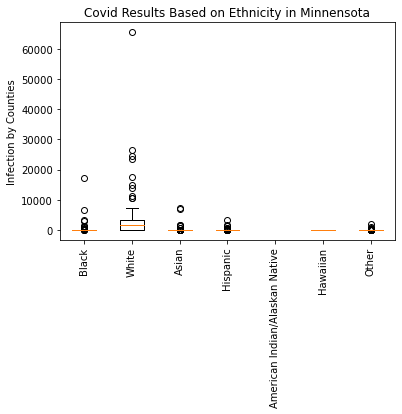

In [21]:
#find quartiles and upper, lower bound, outliers

def boxplot(race):
    covid_box = merged_df.loc[merged_df['Race'] == race]['Infections']
    quartiles = covid_box.quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq - lowerq
    lower_bound = lowerq - (1.5 * iqr)
    upper_bound = upperq + (1.5 * iqr)
    outliers = covid_box.loc[(covid_box < lower_bound) | (covid_box > upper_bound)]
    print(outliers)
    return covid_box


race_1 = boxplot('African American')
race_2 = boxplot('Caucasian')
race_3 = boxplot('Asian')
race_4 = boxplot('Hispanic')
race_5 = boxplot('American Indian/Alaskan Native')
race_6 = boxplot('Hawaiian')
race_7 = boxplot('Other')

plt.boxplot([race_1, race_2, race_3, race_4, race_5, race_6, race_7], labels=['Black', 'White', 'Asian', 'Hispanic', 'American Indian/Alaskan Native', 'Hawaiian', 'Other'])
plt.ylabel('Infection by Counties')
plt.title('Covid Results Based on Ethnicity in Minnensota')
plt.xticks(rotation=90)
plt.show()


# Putting stat summary into dataframe


In [ ]:
# Statistics by county
#lief's groupby
merged_county_gb = merged_df.groupby(["County"])

county_pop_stats = merged_county_gb["Population"].agg(["max", "min", "mean", np.median, "var", "std", "sem"])
county_pov_stats = merged_county_gb["Poverty"].agg(["max", "min", "mean", np.median, "var", "std", "sem"])
county_inf_stats = merged_county_gb["Infections"].agg(["max", "min", "mean", np.median, "var", "std", "sem"])
county_pov_rate_stats = merged_county_gb["Poverty Rate"].agg(["max", "min", "mean", np.median, "var", "std", "sem"])
county_inf_rate_stats = merged_county_gb["Infection Rate"].agg(["max", "min", "mean", np.median, "var", "std", "sem"])

In [ ]:
# county_inf_rate_stats.T

In [ ]:
# merge the county_pov_stats df with county_pove_rate_stats
merged_county_pov_stats_df = pd.merge(county_pov_stats, county_pov_rate_stats, on='County',  how='inner')

#rename columns
col_names = {'max_x':'Cty_Pov_Stats_Max',
            'min_x' :'Cty_Pov_Stats_Min',
            'mean_x' :'Cty_Pov_Stats_Mean',
            'median_x':'Cty_Pov_Stats_Median',
            'var_x':'Cty_Pov_Stats_Variance',
            'std_x':'Cty_Pov_Stats_Std',
            'sem_x':'Cty_Pov_Stats_SEM',
            'max_y':'Cty_Pov_Rate_Max',
            'min_y':'Cty_Pov_Rate_Min',
            'mean_y':'Cty_Pov_Rate_Mean',
            'median_y':'Cty_Pov_Rate_Median',
            'var_y':'Cty_Pov_Rate_Variance',
            'std_y':'Cty_Pov_Rate_Std',
            'sem_y':'Cty_Pov_Rate_SEM'}

merged_county_pov_stats_df = merged_county_pov_stats_df.rename(columns=col_names)
#merged_county_pov_stats_df

In [ ]:
#merge county_inf_stats df with county_inf_rate_stats 

merged_county_inf_stats_df = pd.merge(county_inf_stats, county_inf_rate_stats, on='County', how='inner')

#rename columns

col_names2 = {
            'max_x':'Cty_Infect_Stats_Max',
            'min_x':'Cty_Infect_Stats_Min',
            'mean_x':'Cty_Infect_Stats_Mean',
            'median_x':'Cty_Infect_Stats_Median',
            'var_x':'Cty_Infect_Stats_Variance',
            'std_x':'Cty_Infect_Stats_Std',
            'sem_x':'Cty_Infect_Stats_SEM',
            'max_y':'Cty_Infect_Rate_Max',
            'min_y':'Cty_Infect_Rate_Min',
            'mean_y':'Cty_Infect_Rate_Mean',
            'median_y':'Cty_Infect_Rate_Median',
            'var_y':'Cty_Infect_Rate_Variance',
            'std_y':'Cty_Infect_Rate_Std',
            'sem_y':'Cty_Infect_Rate_SEM'}

merged_county_inf_stats_df = merged_county_inf_stats_df.rename(columns=col_names2)
#merged_county_inf_stats_df

In [ ]:
#merge both df containing the county poverty and county infection
merged_pov_inf_df = pd.merge(merged_county_inf_stats_df, merged_county_pov_stats_df, on='County', how='left')
#merged_pov_inf_df

In [ ]:
#merge the merged_pov_inf_df with county_pop_stats
merged_county_data = pd.merge(merged_pov_inf_df, county_pop_stats, on='County', how='left')
#rename population columns
col_names3 = {
            'max':'Cty_Population_Max',
            'min':'Cty_Population_Min',
            'mean':'Cty_Population_Mean',
            'median':'Cty_Population_Median',
            'var': 'Cty_Population_Variance',
            'std': 'Cty_Population_Std',
            'sem': 'Cty_Population_SEM',
            }
merged_county_data = merged_county_data.rename(columns=col_names3)
merged_county_data

In [ ]:
# Statistics by race

merged_race_gb = merged_df.groupby(["Race"])

race_pop_stats = merged_race_gb["Population"].agg(["max", "min", "mean", np.median, "var", "std", "sem"])
race_pov_stats = merged_race_gb["Poverty"].agg(["max", "min", "mean", np.median, "var", "std", "sem"])
race_inf_stats = merged_race_gb["Infections"].agg(["max", "min", "mean", np.median, "var", "std", "sem"])
race_pov_rate_stats = merged_race_gb["Poverty Rate"].agg(["max", "min", "mean", np.median, "var", "std", "sem"])
race_inf_rate_stats = merged_race_gb["Infection Rate"].agg(["max", "min", "mean", np.median, "var", "std", "sem"])

In [ ]:
#merge race poverty df's 
merged_race_pov_stats = pd.merge(race_pov_stats, race_pov_rate_stats, on='Race', how='inner')
rc_names = {
            'max_x':'Race_Poverty_Max',
            'min_x':'Race_Poverty_Min',
            'mean_x':'Race_Poverty_Mean',
            'median_x':'Race_Poverty_Median',
            'var_x': 'Race_Poverty_Variance',
            'std_x': 'Race_Poverty_Std',
            'sem_x': 'Race_Poverty_SEM',
            'max_y': 'Race_Poverty_Rate_Max',
            'min_y': 'Race_Poverty_Rate_Min',
            'mean_y': 'Race_Poverty_Rate_Mean',
            'median_y': 'Race_Poverty_Rate_Median',
            'var_y': 'Race_Poverty_Rate_Variance',
            'std_y': 'Race_Poverty_Rate_Std',
            'sem_y': 'Race_Poverty_Rate_SEM'
            }
merged_race_pov_stats = merged_race_pov_stats.rename(columns=rc_names)
merged_race_pov_stats

In [ ]:
#merge infection df's
merged_race_inf_stats = pd.merge(race_inf_stats,race_inf_rate_stats, on='Race', how='inner')
#rename columns
rc_names2 = {
            'max_x':'Race_Infect_Max',
            'min_x':'Race_Infect_Min',
            'mean_x':'Race_Infect_Mean',
            'median_x':'Race_Infect_Median',
            'var_x':'Race_Infect_Variance',
            'std_x':'Race_Infect_Std',
            'sem_x':'Race_Infect_SEM',
            'max_y':'Race_Infect_Rate_Max',
            'min_y':'Race_Infect_Rate_Min',
            'mean_y':'Race_Infect_Rate_Mean',
            'median_y':'Race_Infect_Rate_Median',
            'var_y':'Race_Infect_Rate_Variance',
            'std_y':'Race_Infect_Rate_Std',
            'sem_y':'Race_Infect_Rate_SEM'
            }

merged_race_inf_stats = merged_race_inf_stats.rename(columns=rc_names2)
merged_race_inf_stats

In [ ]:
#merge race infect df's with race poverty df's
merged_race_pov_inf = pd.merge(merged_race_inf_stats, merged_race_pov_stats, on='Race', how='left')
merged_race_pov_inf

In [ ]:
#merge previous df with race pop df
merged_race_data = pd.merge(merge_race_pov_inf, race_pop_stats, on='Race', how='left')
#rename population columns
rc_names3 = {
            'max':'Race_Pop_Max',
            'min':'Race_Pop_Min',
            'mean':'Race_Pop_Mean',
            'median':'Race_Pop_Median',
            'var':'Race_Pop_Variance',
            'std':'Race_Pop_Std',
            'sem':'Race_Pop_SEM'
            }
merged_race_data = merged_race_pov_inf_pop.rename(columns=rc_names3)
merged_race_data


In [ ]:
#merge both race data and county data

county_race_df = pd.merge(merged_county_data, merged_race_pov_inf_pop, left_on=['County'] , right_on=['Race'], how='outer')
county_race_df.T

## Mai's Code starts Here

### Bar Charts on Race and Poverty

In [ ]:
# Generate a bar plot showing the total population of race groups, poverty and analyzing the differences of each groups for the merged dataframe
bar_plot_data = merged_df.groupby(['Race']).sum()["Poverty"]
plt.title("The Number of People in Poverty in Minnesota")
plt.xlabel("Race")
plt.ylabel("Poverty")
bar_plot_data.plot.bar(figsize=(8,5),color=('red'), rot=45)

In [ ]:
plot_df = merged_df.groupby(['Race']).sum()
plot_df

In [ ]:
max_pop = plot_df['Population'].max()
max_pop

In [ ]:
# Generate a bar chart to show the max population, poverty and infections of each race in MN
plot_df[['Population','Poverty','Infections']].plot.bar(figsize=(10,15))
plt.xlabel("Race")
plt.ylabel("Population (in millions)")

In [ ]:
# Generate a 3 bar chart to show poverty rate and infection rate for each of the race in MN
plot_df[['Poverty Rate','Infection Rate']].plot.bar(figsize=(10,15))
plt.xlabel("Race")
plt.ylabel("Rate")

## Mai's Boxplots
### Boxplots Based on Race and Poverty

In [ ]:
# Generate a bar plot showing the total population of races and poverty rate
merged_df.boxplot(by='Race', column=['Poverty Rate'], grid=False,figsize=(10, 15))

In [ ]:
# Generate a bar plot showing the total population of races and infections
merged_df.boxplot(by='Race', column=['Infections'], grid=False,figsize=(10, 15))

# Sung's work starts here

 ### keywords: Population in Minnesota (MN), Race, Poverty, Infection rate, Poverty rate
 ### Utilized data from CDC.gov and Population Census datasets.

## Cleaning process to get Number of Infections by Race and County

In [22]:
# Drop NaNs and then sort by date chronologically
cdc_df = cdc_df.dropna(how='any')
cdc_df = cdc_df[['County', 'Race', 'Infections']]
race_mn = cdc_df['Race'].unique()
race_mn = sorted(set(race_mn))
race_mn
cdc_df

,County,Race,Infections
0,ANOKA,African American,2864
1,ANOKA,Asian,1732
2,ANOKA,Caucasian,24501
3,ANOKA,Hispanic,746
4,ANOKA,Native American,73
...,...,...,...
172,WRIGHT,African American,107
173,WRIGHT,Asian,49
174,WRIGHT,Caucasian,10656
175,WRIGHT,Hispanic,109


## Number of Infections by Race and County
   ### a) Total infections for African American.

In [23]:
#total sum of infections of African American.
cdc_infections_african_american_df = cdc_df.loc[  cdc_df['Race'] == race_mn[0]]
cdc_infections_african_american_df = cdc_infections_african_american_df.groupby(['County', 'Race'])
cdc_infections_african_american_sum_df = cdc_infections_african_american_df.sum()
cdc_infections_african_american_sum_df.head()

,,Infections
County,Race,
ANOKA,African American,2864
BELTRAMI,African American,3
BENTON,African American,104
BLUE EARTH,African American,213
CARLTON,African American,13


In [24]:
cdc_infections_african_american_total = cdc_infections_african_american_sum_df['Infections'].sum()
cdc_infections_african_american_total

36467

### b) Total infections for Asian.

In [25]:
#total sum of infections of Asians
cdc_infections_asian_df = cdc_df.loc[  cdc_df['Race'] == race_mn[1]]
cdc_infections_asian_df = cdc_infections_asian_df.groupby(['County', 'Race'])
cdc_infections_asian_sum_df = cdc_infections_asian_df.sum()
cdc_infections_asian_sum_df.head()

,,Infections
County,Race,
ANOKA,Asian,1732
BLUE EARTH,Asian,30
CARVER,Asian,123
CHISAGO,Asian,14
CLAY,Asian,6


In [26]:
cdc_infections_asian_total = cdc_infections_asian_sum_df['Infections'].sum()
cdc_infections_asian_total

20792

### c) Total infections for Caucasian American.

In [27]:
cdc_infections_caucasian_df = cdc_df.loc[  cdc_df['Race'] == race_mn[2]]
cdc_infections_caucasian_df = cdc_infections_caucasian_df.groupby(['County', 'Race'])
cdc_infections_caucasian_sum_df = cdc_infections_caucasian_df.sum()
cdc_infections_caucasian_sum_df.head()

,,Infections
County,Race,
ANOKA,Caucasian,24501
BECKER,Caucasian,1992
BELTRAMI,Caucasian,2216
BENTON,Caucasian,4164
BLUE EARTH,Caucasian,4555


In [28]:
cdc_infections_caucasian_total = cdc_infections_caucasian_sum_df['Infections'].sum()
cdc_infections_caucasian_total

328541

### d) Total infections for Hispanic.

In [29]:
#total sum of infections of asians in 2021
cdc_infections_hispanic_df = cdc_df.loc[  cdc_df['Race'] == race_mn[3]]
cdc_infections_hispanic_df = cdc_infections_hispanic_df.groupby(['County', 'Race'])
cdc_infections_hispanic_sum_df = cdc_infections_hispanic_df.sum()
cdc_infections_hispanic_sum_df.head()

,,Infections
County,Race,
ANOKA,Hispanic,746
BENTON,Hispanic,1
BLUE EARTH,Hispanic,50
BROWN,Hispanic,46
CARVER,Hispanic,179


In [30]:
cdc_infections_hispanic_total = cdc_infections_hispanic_sum_df['Infections'].sum()
cdc_infections_hispanic_total

10265

### e) Total infections for Native American.

In [31]:
#total sum of infections of Native American in 2021
cdc_infections_native_american_df = cdc_df.loc[  cdc_df['Race'] == race_mn[4]]
cdc_infections_native_american_df = cdc_infections_native_american_df.groupby(['County', 'Race'])
cdc_infections_native_american_sum_df = cdc_infections_native_american_df.sum()
cdc_infections_native_american_sum_df.head()

,,Infections
County,Race,
ANOKA,Native American,73
BECKER,Native American,228
BELTRAMI,Native American,1064
CARLTON,Native American,64
CASS,Native American,195


In [32]:
cdc_infections_native_american_total = cdc_infections_native_american_sum_df['Infections'].sum()
cdc_infections_native_american_total

3045

### f) Total infections for other.

In [33]:
#total sum of infections of other in 2021
cdc_infections_other_df = cdc_df.loc[  cdc_df['Race'] == race_mn[5]]
cdc_infections_other_df = cdc_infections_other_df.groupby(['County', 'Race'])
cdc_infections_other_sum_df = cdc_infections_other_df.sum()
cdc_infections_other_sum_df.head()

,,Infections
County,Race,
ANOKA,Other,348
BECKER,Other,2
BELTRAMI,Other,33
BENTON,Other,12
BLUE EARTH,Other,21


In [34]:
cdc_infections_other_total = cdc_infections_other_sum_df['Infections'].sum()
cdc_infections_other_total

5499

In [35]:
african_american_asian_combined_df = pd.merge(cdc_infections_african_american_sum_df, cdc_infections_asian_sum_df, on=['County'], how = "outer")
african_american_asian_caucasian_combined_df = pd.merge(african_american_asian_combined_df, cdc_infections_caucasian_sum_df, on=['County'], how = "outer")
african_american_asian_caucasian_hispanic_combined_df = pd.merge(african_american_asian_caucasian_combined_df, cdc_infections_hispanic_sum_df, on=['County'], how = "outer")
african_american_asian_caucasian_hispanic_native_american_combined_df = pd.merge(african_american_asian_caucasian_hispanic_combined_df, cdc_infections_native_american_sum_df, on=['County'], how = "outer")

C:\Users\Sung\AppData\Local\Temp\ipykernel_21284\37040428.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Infections_x'} in the result is deprecated and will raise a MergeError in a future version.
  african_american_asian_caucasian_hispanic_combined_df = pd.merge(african_american_asian_caucasian_combined_df, cdc_infections_hispanic_sum_df, on=['County'], how = "outer")


In [36]:
# Rename columns. FINAL summary table
comprehensive_df = pd.merge(african_american_asian_caucasian_hispanic_native_american_combined_df, cdc_infections_other_sum_df, on=['County'], how = "outer")
comprehensive_df.columns = ['African American Infections', 'Asian Infections', 'Caucasian American Infections', 'Hispanic Infections', 'Native American Infections', 'Other Infections']
# comprehensive_clean_df = comprehensive_df.fillna(0)
comprehensive_df.head()

C:\Users\Sung\AppData\Local\Temp\ipykernel_21284\463087753.py:2: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Infections_x'} in the result is deprecated and will raise a MergeError in a future version.
  comprehensive_df = pd.merge(african_american_asian_caucasian_hispanic_native_american_combined_df, cdc_infections_other_sum_df, on=['County'], how = "outer")


,African American Infections,Asian Infections,Caucasian American Infections,Hispanic Infections,Native American Infections,Other Infections
County,,,,,,
ANOKA,2864.0,1732.0,24501,746.0,73.0,348.0
BELTRAMI,3.0,NaN,2216,NaN,1064.0,33.0
BENTON,104.0,NaN,4164,1.0,NaN,12.0
BLUE EARTH,213.0,30.0,4555,50.0,NaN,21.0
CARLTON,13.0,NaN,1838,NaN,64.0,6.0


In [37]:
#summary of number of infections by race
total_infection_byrace = [cdc_infections_african_american_total, cdc_infections_asian_total, 
                               cdc_infections_caucasian_total, cdc_infections_hispanic_total, 
                               cdc_infections_native_american_total, cdc_infections_other_total]
for (race, infection) in zip(race_mn, total_infection_byrace):
    print(f" {race}: {infection}")

 African American: 36467
 Asian: 20792
 Caucasian: 328541
 Hispanic: 10265
 Native American: 3045
 Other: 5499


In [38]:
#population by race infected with covid-19

mn_pop = mn_pop_df['Population Total']
mn_caucasian_pop = mn_pop_df['Caucasian']
mn_african_american_pop = mn_pop_df['African American']
mn_native_american_pop = mn_pop_df['Native American']
mn_asian_pop = mn_pop_df['Asian']
mn_hawaiian_pop = mn_pop_df['Hawaiian']
mn_hispanic_pop = mn_pop_df['Hispanic']
mn_other_pop = mn_pop_df['Other']

mn_pop_list = list(mn_pop)
mn_pop_list
mn_caucasian_list = list(mn_caucasian_pop)
mn_caucasian_list
mn_african_american_list = list(mn_african_american_pop)
mn_african_american_list
mn_native_american_list = list(mn_native_american_pop)
mn_native_american_list
mn_asian_list = list(mn_asian_pop)
mn_asian_list
mn_hawaiian_list = list(mn_hawaiian_pop)
mn_hawaiian_list
mn_hispanic_list = list(mn_hispanic_pop)
mn_hispanic_list
mn_other_list = list(mn_other_pop)
mn_other_list
print(type(mn_pop_list[0]))

#converting string to integer
# print([int(x) for x in mn_pop_list])
mn_pop_int_list = [int(x) for x in mn_pop_list]
mn_caucasian_int_list = [int(x) for x in mn_caucasian_list]
mn_african_american_int_list = [int(x) for x in mn_african_american_list]
mn_native_american_int_list = [int(x) for x in mn_native_american_list]
mn_asian_int_list = [int(x) for x in mn_asian_list]
mn_hawaiian_int_list = [int(x) for x in mn_hawaiian_list]
mn_hispanic_int_list = [int(x) for x in mn_hispanic_list]
mn_other_int_list = [int(x) for x in mn_other_list]


print(type(mn_pop_int_list[0]))

<class 'str'>
<class 'int'>


In [39]:
#sum
sum_mn_pop = sum(mn_pop_int_list)
sum_mn_caucasian = sum(mn_caucasian_int_list)
sum_mn_african_american = sum(mn_african_american_int_list)
sum_mn_native_american = sum(mn_native_american_int_list)
sum_mn_asian = sum(mn_asian_int_list)
sum_mn_hawaiian = sum(mn_hawaiian_int_list)
sum_mn_hispanic = sum(mn_hispanic_int_list)
sum_mn_other = sum(mn_other_int_list)

#percent
percent_mn_caucasian = sum_mn_caucasian/sum_mn_pop*100
percent_mn_african_american = sum_mn_african_american/sum_mn_pop*100
percent_mn_native_american = sum_mn_native_american/sum_mn_pop*100
percent_mn_asian = sum_mn_asian/sum_mn_pop*100
percent_mn_hawaiian = sum_mn_hawaiian/sum_mn_pop*100
percent_mn_hispanic = sum_mn_hispanic/sum_mn_pop*100
percent_mn_other = sum_mn_other/sum_mn_pop*100

## Population in MN by race

In [40]:
#summary of population by race
population_by_race_summary = [sum_mn_pop, sum_mn_caucasian, sum_mn_african_american, 
                              sum_mn_native_american, sum_mn_asian, sum_mn_hawaiian, 
                              sum_mn_hispanic, sum_mn_other]
MN_population = ['Population', 'Caucasian', 'African American', 'Native American', 'Asian', 'Hawaiian', 'Hispanic', 'Other']
for (racepopulation, mnsum) in zip(MN_population, population_by_race_summary):
    print(f" {racepopulation}: {mnsum}")

 Population: 5600166
 Caucasian: 4422490
 African American: 354540
 Native American: 48409
 Asian: 273100
 Hawaiian: 1905
 Hispanic: 307675
 Other: 192047


## Population % in MN by race

In [41]:
#summary of population by race
population_per_by_race_summary = [percent_mn_caucasian, percent_mn_african_american, percent_mn_native_american,
                              percent_mn_asian, percent_mn_hawaiian, percent_mn_hispanic, percent_mn_other]
race_in_MN = ['Caucasian', 'African American', 'Native American', 'Asian', 'Hawaiian', 'Hispanic', 'Other']
for (racepopulation, per) in zip(race_in_MN, population_per_by_race_summary):
    print(f" {racepopulation}: {per}")

 Caucasian: 78.97069479726136
 African American: 6.330883763088452
 Native American: 0.8644208046690045
 Asian: 4.876641156708569
 Hawaiian: 0.03401684878626812
 Hispanic: 5.494033569719183
 Other: 3.429309059767157


In [42]:
#infection rate African American
african_american_infection_percent = (cdc_infections_african_american_total / sum_mn_african_american ) *100
african_american_infection_percent

#infection rate Asian
asian_infection_percent = (cdc_infections_asian_total / sum_mn_asian ) *100
asian_infection_percent

#infection rate Caucasian
caucasian_infection_percent = (cdc_infections_caucasian_total / sum_mn_caucasian ) *100
caucasian_infection_percent

#infection rate hispanic
hispanic_infection_percent = (cdc_infections_hispanic_total / sum_mn_hispanic ) *100
hispanic_infection_percent

#infection rate native american
native_american_infection_percent = (cdc_infections_native_american_total / sum_mn_native_american ) *100
native_american_infection_percent


other_infection_percent = (cdc_infections_other_total / sum_mn_other ) *100
other_infection_percent


percentage_race_infections = [african_american_infection_percent, asian_infection_percent, 
                              caucasian_infection_percent, hispanic_infection_percent, native_american_infection_percent, other_infection_percent]



In [43]:
sum_non_caucasian_population = sum_mn_african_american + sum_mn_native_american + sum_mn_asian + sum_mn_hawaiian + sum_mn_hispanic + sum_mn_other
sum_non_caucasian_population
non_caucasian_infection_rate = sum_non_caucasian_population / sum_mn_pop
non_caucasian_infection_rate
sum_non_caucasian_population_infection = cdc_infections_african_american_total + cdc_infections_asian_total +cdc_infections_hispanic_total + cdc_infections_native_american_total + cdc_infections_other_total
sum_non_caucasian_population_infection

non_caucaisan_infection_percent1 = sum_non_caucasian_population_infection / sum_non_caucasian_population
non_caucasian_infection_ratio = non_caucaisan_infection_percent1 / non_caucasian_infection_rate
non_caucasian_infection_ratio

0.3071505159301395

In [44]:
#rate corrected by population,% (non-whites)
african_american_infection_percent_corrected = african_american_infection_percent / percent_mn_african_american
african_american_infection_percent_corrected
asian_infection_percent_corrected = asian_infection_percent / percent_mn_asian
hispanic_infection_percent_corrected = hispanic_infection_percent / percent_mn_hispanic
native_american_infection_percent_corrected = native_american_infection_percent / percent_mn_native_american
other_infection_percent_corrected = other_infection_percent / percent_mn_other


#rate corrected by population,% (whites)
caucasian_infection_percent_corrected = caucasian_infection_percent / percent_mn_caucasian



## Summary table of the Infection rate, % (Number of infections / Total Census Population of Race) of different racial groups in Minnesota from March 2020 to April 2022 

In [45]:
# Dataframe showing infection rate
race_percent_df = pd.DataFrame({'African American':[african_american_infection_percent],
                     'Asian':[asian_infection_percent],
                     'Caucasian American':[caucasian_infection_percent],
                     'Hispanic':[hispanic_infection_percent],
                     'Native American':[native_american_infection_percent],
                     'Other':[other_infection_percent] 
                               })

# Declare a list that is to be converted into a column
# Dataframe showing infection rate
State = ['Infection rate by race group']
race_percent_df['Minnesota'] = State
race_percent_df = race_percent_df.reindex(columns=['Minnesota', 'African American', 'Asian', 'Caucasian American', 'Hispanic',
       'Native American', 'Other'])
race_percent_df

,Minnesota,African American,Asian,Caucasian American,Hispanic,Native American,Other
0,Infection rate by race group,10.285722,7.613328,7.428869,3.336313,6.290153,2.863362


In [46]:
# Dataframe showing infection rate or ratio by group (corrected by % population)

race_percent_corrected_df = pd.DataFrame({'African American':[african_american_infection_percent_corrected],
                     'Asian':[asian_infection_percent_corrected],
                     'Caucasian American':[caucasian_infection_percent_corrected],
                     'Hispanic':[hispanic_infection_percent_corrected],
                     'Native American':[native_american_infection_percent_corrected],
                     'Other':[other_infection_percent_corrected] 
                               })

# Declare a list that is to be converted into a column
# Dataframe showing infection rate or ratio by group (corrected by % population)
State = ['Infection rate by race group']
race_percent_corrected_df['Minnesota'] = State
race_percent_corrected_df = race_percent_corrected_df.reindex(columns=['Minnesota', 'African American', 'Asian', 'Caucasian American', 'Hispanic',
       'Native American', 'Other'])
race_percent_corrected_df

,Minnesota,African American,Asian,Caucasian American,Hispanic,Native American,Other
0,Infection rate by race group,1.62469,1.561183,0.094071,0.607261,7.276725,0.834967


## Infection rate, % of Caucasian and Non-Caucasian in Minnesota from March 2020 to April 2022
    a) Caucasian vs Non-caucasian

In [47]:
# Dataframe showing infection rate

#Adding a column.
# sum of non-caucasian columns
# Create List of columns
non_caucasian_list= ['African American', 'Asian',
       'Hispanic', 'Native American', 'Other']

race_percent_df['Non-Caucasian American'] = (race_percent_df[non_caucasian_list].sum(axis=1)) / 5
race_percent_df
race_percent_df = race_percent_df[['Minnesota', 'Caucasian American', 'Non-Caucasian American' ]]
race_percent_df

,Minnesota,Caucasian American,Non-Caucasian American
0,Infection rate by race group,7.428869,6.077776


## Infection ratio (Infection rate / % population of race) of Caucasian and Non-Caucasian in Minnesota

In [48]:
# Dataframe showing infection rate or ratio by group (corrected by % population)

#Adding a column.
# sum of non-caucasian columns
# Create List of columns
non_caucasian_list= ['African American', 'Asian',
       'Hispanic', 'Native American', 'Other']

race_percent_corrected_df['Non-Caucasian American'] = non_caucasian_infection_ratio
race_percent_corrected_df
race_percent_summary_df = race_percent_corrected_df[['Minnesota', 'Caucasian American', 'Non-Caucasian American' ]]
race_percent_summary_df

,Minnesota,Caucasian American,Non-Caucasian American
0,Infection rate by race group,0.094071,0.307151


## Hypothesis Test #1
### $H_{0}$: Is the mean of the covid infection ratio of caucasian group equal to the mean of that of non-caucasian group?

In [49]:
# Select column of interests and merge.
mn_pop_race_df = mn_pop_df[['County', 'African American', 'Asian', 'Caucasian', 'Native American', 'Hispanic', 'Other']]
cdc_census_combined_df = pd.merge(comprehensive_df, mn_pop_race_df, on=['County'], how = "outer")
cdc_census_clean_combined_df = cdc_census_combined_df.fillna(0)
cdc_census_clean_combined_df

,County,African American Infections,Asian Infections,Caucasian American Infections,Hispanic Infections,Native American Infections,Other Infections,African American,Asian,Caucasian,Native American,Hispanic,Other
0,ANOKA,2864.0,1732.0,24501.0,746.0,73.0,348.0,23534,16082,283436,1788,16769,12080
1,BELTRAMI,3.0,0.0,2216.0,0.0,1064.0,33.0,399,295,33506,8920,1114,2514
2,BENTON,104.0,0.0,4164.0,1.0,0.0,12.0,1876,378,35979,49,1086,1108
3,BLUE EARTH,213.0,30.0,4555.0,50.0,0.0,21.0,2794,1516,58852,139,2579,1473
4,CARLTON,13.0,0.0,1838.0,0.0,64.0,6.0,909,231,31459,1462,638,1010
...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,LINCOLN,0.0,0.0,0.0,0.0,0.0,0.0,13,31,5394,10,119,74
83,MAHNOMEN,0.0,0.0,0.0,0.0,0.0,0.0,40,19,2468,1963,257,756
84,PIPESTONE,0.0,0.0,0.0,0.0,0.0,0.0,27,71,8007,110,662,286
85,RENVILLE,0.0,0.0,0.0,0.0,0.0,0.0,67,108,12741,186,1268,202


In [50]:
#converting all the rows to integer
column_list = ['African American Infections', 'Asian Infections',
       'Caucasian American Infections', 'Hispanic Infections',
       'Native American Infections', 'Other Infections', 'African American',
       'Asian', 'Caucasian', 'Native American', 'Hispanic', 'Other']

for column in column_list:
    cdc_census_clean_combined_df[column] = cdc_census_clean_combined_df[column].astype(int)

In [51]:
# african american population by county DATAFRAME
cdc_census_clean_combined_african_american_df = cdc_census_clean_combined_df['African American']
cdc_census_clean_combined_african_american_df


0     23534
1       399
2      1876
3      2794
4       909
      ...  
82       13
83       40
84       27
85       67
86      124
Name: African American, Length: 87, dtype: int32

In [52]:
# Total racial Population by county DATAFRAME
cdc_census_clean_combined_asian_df = cdc_census_clean_combined_df['Asian']
cdc_census_clean_combined_caucasian_df = cdc_census_clean_combined_df['Caucasian']
cdc_census_clean_combined_native_american_df = cdc_census_clean_combined_df['Native American']
cdc_census_clean_combined_hispanic_df = cdc_census_clean_combined_df['Hispanic']
cdc_census_clean_combined_other_df = cdc_census_clean_combined_df['Other']

#total caucasian population by county DATAFRAME
cdc_census_clean_combined_caucasian_df

0     283436
1      33506
2      35979
3      58852
4      31459
       ...  
82      5394
83      2468
84      8007
85     12741
86     13876
Name: Caucasian, Length: 87, dtype: int32

In [53]:
# total population by county
cdc_census_clean_combined_sum_df = (cdc_census_clean_combined_african_american_df + cdc_census_clean_combined_caucasian_df + cdc_census_clean_combined_asian_df + cdc_census_clean_combined_native_american_df + cdc_census_clean_combined_hispanic_df + cdc_census_clean_combined_other_df)
cdc_census_clean_combined_sum_df

0     353689
1      46748
2      40476
3      67353
4      35709
       ...  
82      5641
83      5503
84      9163
85     14572
86     15259
Length: 87, dtype: int32

In [54]:
# total population by county for non-caucasian group
cdc_census_clean_combined_sum_non_caucasian_df = (cdc_census_clean_combined_african_american_df + cdc_census_clean_combined_asian_df + cdc_census_clean_combined_native_american_df + cdc_census_clean_combined_hispanic_df + cdc_census_clean_combined_other_df)
cdc_census_clean_combined_sum_non_caucasian_df

0     70253
1     13242
2      4497
3      8501
4      4250
      ...  
82      247
83     3035
84     1156
85     1831
86     1383
Length: 87, dtype: int32

In [55]:
# number of infections by county non-caucasian group DATAFRAME
african_american_infection_df = cdc_census_clean_combined_df['African American Infections']
asian_infection_df = cdc_census_clean_combined_df['Asian Infections']
native_american_infection_df = cdc_census_clean_combined_df[ 'Native American Infections']
hispanic_infection_df = cdc_census_clean_combined_df['Hispanic Infections']
other_infection_df = cdc_census_clean_combined_df['Other Infections']

# number of infections by county caucasian group
caucasian_infection_df = cdc_census_clean_combined_df['Caucasian American Infections']
caucasian_infection_df

0     24501
1      2216
2      4164
3      4555
4      1838
      ...  
82        0
83        0
84        0
85        0
86        0
Name: Caucasian American Infections, Length: 87, dtype: int32

In [56]:
#SUM OF number of infections NON-CACUASIAN DATAFRAME
sum_non_caucasian_infection_df = african_american_infection_df + asian_infection_df + native_american_infection_df + hispanic_infection_df + other_infection_df
sum_non_caucasian_infection_df

0     5763
1     1100
2      117
3      314
4       83
      ... 
82       0
83       0
84       0
85       0
86       0
Length: 87, dtype: int32

In [57]:
# Population racial % by county
#non-caucasian group
county_asian_pop_percent = cdc_census_clean_combined_asian_df / cdc_census_clean_combined_sum_df
county_african_american_pop_percent = cdc_census_clean_combined_african_american_df / cdc_census_clean_combined_sum_df
county_native_american_pop_percent = cdc_census_clean_combined_native_american_df / cdc_census_clean_combined_sum_df
county_hispanic_pop_percent = cdc_census_clean_combined_hispanic_df / cdc_census_clean_combined_sum_df
county_other_pop_percent = cdc_census_clean_combined_asian_df / cdc_census_clean_combined_sum_df

#SUM OF NON-CACUASIAN DATAFRAME
sum_non_caucasian_pop_percent_df = county_asian_pop_percent + county_african_american_pop_percent + county_native_american_pop_percent + county_hispanic_pop_percent + county_other_pop_percent


# caucasian group
county_caucasian_pop_percent = cdc_census_clean_combined_caucasian_df / cdc_census_clean_combined_sum_df
county_caucasian_pop_percent

0     0.801371
1     0.716737
2     0.888897
3     0.873784
4     0.880982
        ...   
82    0.956213
83    0.448483
84    0.873840
85    0.874348
86    0.909365
Length: 87, dtype: float64

In [58]:
# infection rate calculation non-caucasian group
non_caucasian_infection_rate_corrected_df = (sum_non_caucasian_infection_df / cdc_census_clean_combined_sum_df) / sum_non_caucasian_pop_percent_df

# infection rate calculation african american group
african_american_infection_rate_corrected_df = (african_american_infection_df / cdc_census_clean_combined_sum_df) / county_african_american_pop_percent
asian_infection_rate_corrected_df = (asian_infection_df / cdc_census_clean_combined_sum_df) / county_asian_pop_percent
native_american_infection_rate_corrected_df = (native_american_infection_df / cdc_census_clean_combined_sum_df) / county_native_american_pop_percent
hispanic_infection_rate_corrected_df = (hispanic_infection_df / cdc_census_clean_combined_sum_df) / county_hispanic_pop_percent
other_infection_rate_corrected_df = (other_infection_df / cdc_census_clean_combined_sum_df) / county_other_pop_percent



# number of infections by county caucasian group
caucasian_infection_rate_corrected_df = (caucasian_infection_df / cdc_census_clean_combined_sum_df) / county_caucasian_pop_percent
caucasian_infection_rate_corrected_df

0     0.086443
1     0.066137
2     0.115734
3     0.077398
4     0.058425
        ...   
82    0.000000
83    0.000000
84    0.000000
85    0.000000
86    0.000000
Length: 87, dtype: float64

## Summary table of infection ratio (Infection rate / % population of race) of caucasian and non-caucasian groups by County

In [59]:
#filter to just show County column
cdc_census_combined_summary_df = cdc_census_clean_combined_df[['County']]
cdc_census_combined_summary_df


cdc_census_combined_summary_df[  'Non-Caucasian infection ratio'  ] = non_caucasian_infection_rate_corrected_df
cdc_census_combined_summary_df[  'Caucasian infection ratio'  ] = caucasian_infection_rate_corrected_df
cdc_census_combined_summary_df

C:\Users\Sung\AppData\Local\Temp\ipykernel_21284\3354194440.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdc_census_combined_summary_df[  'Non-Caucasian infection ratio'  ] = non_caucasian_infection_rate_corrected_df
C:\Users\Sung\AppData\Local\Temp\ipykernel_21284\3354194440.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdc_census_combined_summary_df[  'Caucasian infection ratio'  ] = caucasian_infection_rate_corrected_df


,County,Non-Caucasian infection ratio,Caucasian infection ratio
0,ANOKA,0.077611,0.086443
1,BELTRAMI,0.099791,0.066137
2,BENTON,0.031059,0.115734
3,BLUE EARTH,0.036751,0.077398
4,CARLTON,0.023912,0.058425
...,...,...,...
82,LINCOLN,0.000000,0.000000
83,MAHNOMEN,0.000000,0.000000
84,PIPESTONE,0.000000,0.000000
85,RENVILLE,0.000000,0.000000


In [60]:
# Calculate the mean for infection rate of non-caucasian group
non_caucasian_infection_rate_corrected = cdc_census_combined_summary_df['Non-Caucasian infection ratio'].fillna(0)
non_caucasian_infection_rate_corrected.mean()
# non_caucasian_infection_rate = cdc_census_combined_summary_df['Non-Caucasian infection rate'].to_numpy()
# np.where(non_caucasian_infection_rate != np.nan)

0.017302001144590733

In [61]:
# Calculate the mean for infection rate of caucasian group
caucasian_infection_rate_corrected = cdc_census_combined_summary_df['Caucasian infection ratio']
caucasian_infection_rate_corrected.mean()

0.04401037815918566

In [77]:
# Calculate Independent (Two Sample) t-test
st.ttest_ind(non_caucasian_infection_rate_corrected, caucasian_infection_rate_corrected, equal_var=False)

# nan_policy="omit"

Ttest_indResult(statistic=-5.1901241768312865, pvalue=7.079360028131798e-07)

In [89]:
print("we reject the null hypothesis; p-value is lower than 0.05")

we reject the null hypothesis; p-value is lower than 0.05


## Hypothesis Test #2
### ANOVA test- Null Hypothesis: is mean of different racial groups  equal across the race?

In [64]:
#dataframe showing infection rate by group (corrected by % population)

county_list = ['ANOKA', 'BELTRAMI', 'BENTON', 'BLUE EARTH', 'CARLTON', 'CARVER',
       'CHISAGO', 'CLAY', 'DAKOTA', 'GOODHUE', 'HENNEPIN', 'KANDIYOHI',
       'LYON', 'MOWER', 'NICOLLET', 'NOBLES', 'OLMSTED', 'OTTER TAIL',
       'PINE', 'POLK', 'RAMSEY', 'RICE', 'SCOTT', 'SHERBURNE',
       'ST. LOUIS', 'STEARNS', 'STEELE', 'WASHINGTON', 'WINONA', 'WRIGHT',
       'FREEBORN', 'ISANTI', 'BECKER', 'BROWN', 'CASS', 'CROW WING',
       'DODGE', 'DOUGLAS', 'FILLMORE', 'HUBBARD', 'ITASCA', 'LE SUEUR',
       'MCLEOD', 'MEEKER', 'MILLE LACS', 'MORRISON', 'TODD', 'WABASHA',
       'BIG STONE', 'CHIPPEWA', 'WATONWAN', 'WADENA', 'CLEARWATER',
       'COOK', 'COTTONWOOD', 'FARIBAULT', 'GRANT', 'HOUSTON', 'KANABEC',
       'KOOCHICHING', 'LAC QUI PARLE', 'LAKE OF THE WOODS', 'MARSHALL',
       'MARTIN', 'MURRAY', 'NORMAN', 'PENNINGTON', 'POPE', 'RED LAKE',
       'REDWOOD', 'ROCK', 'SIBLEY', 'STEVENS', 'SWIFT', 'TRAVERSE',
       'WASECA', 'WILKIN', 'YELLOW MEDICINE', 'AITKIN', 'JACKSON',
       'KITTSON', 'LAKE', 'LINCOLN', 'MAHNOMEN', 'PIPESTONE', 'RENVILLE',
       'ROSEAU']

cdc_census_combined_allrace_summary_df = pd.DataFrame({'County': county_list,
                     'African American': african_american_infection_rate_corrected_df,
                     'Asian': asian_infection_rate_corrected_df,
                     'Caucasian American': caucasian_infection_rate_corrected_df,
                     'Hispanic': hispanic_infection_rate_corrected_df,
                     'Native American': native_american_infection_rate_corrected_df,
                     'Other': other_infection_rate_corrected_df 
                               })

cdc_census_combined_allrace_summary_df

,County,African American,Asian,Caucasian American,Hispanic,Native American,Other
0,ANOKA,0.121696,0.107698,0.086443,0.044487,0.040828,0.021639
1,BELTRAMI,0.007519,0.000000,0.066137,0.000000,0.119283,0.111864
2,BENTON,0.055437,0.000000,0.115734,0.000921,0.000000,0.031746
3,BLUE EARTH,0.076235,0.019789,0.077398,0.019387,0.000000,0.013852
4,CARLTON,0.014301,0.000000,0.058425,0.000000,0.043776,0.025974
...,...,...,...,...,...,...,...
82,LINCOLN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
83,MAHNOMEN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
84,PIPESTONE,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
85,RENVILLE,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [65]:
#declare groups
group0 = african_american_infection_rate_corrected_df.fillna(0)
group1 = asian_infection_rate_corrected_df.fillna(0)
group2 = caucasian_infection_rate_corrected_df.fillna(0)
group3 = hispanic_infection_rate_corrected_df.fillna(0)
group4 = native_american_infection_rate_corrected_df.fillna(0)
group5 = other_infection_rate_corrected_df.fillna(0)

# group1 = asian_infection_rate_corrected_df.fillna(0).to_numpy()

In [72]:
#ANOVA test
# Perform the ANOVA
st.f_oneway(group0, group1, group2, group3, group4, group5)

F_onewayResult(statistic=17.3425137885665, pvalue=6.981632475560612e-16)

In [74]:
#ANOVA test
# Perform the ANOVA
st.f_oneway(group0, group1, group2)


F_onewayResult(statistic=19.55229979643388, pvalue=1.2406024958051865e-08)

In [75]:
#ANOVA test
# Perform the ANOVA
st.f_oneway(group0, group2)



F_onewayResult(statistic=12.030496846023901, pvalue=0.0006613499091773455)

In [90]:
print("we reject the null hypothesis; p-value is lower than 0.05")

we reject the null hypothesis; p-value is lower than 0.05


## Hypothesis Test #3
### Poverty rate independent t-test

In [79]:
merged_df_metro.head(10)

,Metro-Non,County,Two-Races,Population,Poverty,Infections,Poverty Rate,Infection Rate
0,Non_Metro,AITKIN,Non-Caucasian,61,13,0,0.213115,0.000000
1,Non_Metro,AITKIN,Non-Caucasian,40,0,0,0.000000,0.000000
2,Non_Metro,AITKIN,Caucasian,14831,1711,0,0.115366,0.000000
3,Non_Metro,AITKIN,Non-Caucasian,9,0,0,0.000000,0.000000
4,Non_Metro,AITKIN,Non-Caucasian,216,45,0,0.208333,0.000000
5,Non_Metro,AITKIN,Non-Caucasian,327,82,0,0.250765,0.000000
6,Non_Metro,AITKIN,Non-Caucasian,342,61,0,0.178363,0.000000
7,Metro,ANOKA,Non-Caucasian,23534,3697,2864,0.157092,0.121696
8,Metro,ANOKA,Non-Caucasian,16082,953,1732,0.059259,0.107698
9,Metro,ANOKA,Caucasian,283436,11778,24501,0.041554,0.086443


In [80]:
infection_poverty_rate_df = merged_df_metro['Poverty Rate'] * merged_df_metro['Infection Rate']
infection_poverty_rate_df.head(10)

0    0.000000
1    0.000000
2    0.000000
3    0.000000
4    0.000000
5    0.000000
6    0.000000
7    0.019117
8    0.006382
9    0.003592
dtype: float64

In [81]:
#Adding a column.
# Create List of columns

merged_df_metro['Infection poverty rate'] = infection_poverty_rate_df
merged_df_metro.head(15)

,Metro-Non,County,Two-Races,Population,Poverty,Infections,Poverty Rate,Infection Rate,Infection poverty rate
0,Non_Metro,AITKIN,Non-Caucasian,61,13,0,0.213115,0.000000,0.000000
1,Non_Metro,AITKIN,Non-Caucasian,40,0,0,0.000000,0.000000,0.000000
2,Non_Metro,AITKIN,Caucasian,14831,1711,0,0.115366,0.000000,0.000000
3,Non_Metro,AITKIN,Non-Caucasian,9,0,0,0.000000,0.000000,0.000000
4,Non_Metro,AITKIN,Non-Caucasian,216,45,0,0.208333,0.000000,0.000000
5,Non_Metro,AITKIN,Non-Caucasian,327,82,0,0.250765,0.000000,0.000000
6,Non_Metro,AITKIN,Non-Caucasian,342,61,0,0.178363,0.000000,0.000000
7,Metro,ANOKA,Non-Caucasian,23534,3697,2864,0.157092,0.121696,0.019117
8,Metro,ANOKA,Non-Caucasian,16082,953,1732,0.059259,0.107698,0.006382
9,Metro,ANOKA,Caucasian,283436,11778,24501,0.041554,0.086443,0.003592


In [82]:
merged_df_metro_group = merged_df_metro.groupby(['Metro-Non', 'Two-Races'])
merged_df_metro_group = merged_df_metro_group.head()
merged_df_metro_group

,Metro-Non,County,Two-Races,Population,Poverty,Infections,Poverty Rate,Infection Rate,Infection poverty rate
0,Non_Metro,AITKIN,Non-Caucasian,61,13,0,0.213115,0.000000,0.000000
1,Non_Metro,AITKIN,Non-Caucasian,40,0,0,0.000000,0.000000,0.000000
2,Non_Metro,AITKIN,Caucasian,14831,1711,0,0.115366,0.000000,0.000000
3,Non_Metro,AITKIN,Non-Caucasian,9,0,0,0.000000,0.000000,0.000000
4,Non_Metro,AITKIN,Non-Caucasian,216,45,0,0.208333,0.000000,0.000000
5,Non_Metro,AITKIN,Non-Caucasian,327,82,0,0.250765,0.000000,0.000000
7,Metro,ANOKA,Non-Caucasian,23534,3697,2864,0.157092,0.121696,0.019117
8,Metro,ANOKA,Non-Caucasian,16082,953,1732,0.059259,0.107698,0.006382
9,Metro,ANOKA,Caucasian,283436,11778,24501,0.041554,0.086443,0.003592
10,Metro,ANOKA,Non-Caucasian,86,0,0,0.000000,0.000000,0.000000


In [83]:

merged_df_metro_group_non_metro = merged_df_metro_group.loc[  merged_df_metro_group['Metro-Non'] == 'Non_Metro']
merged_df_metro_group_non_metro = merged_df_metro_group_non_metro[['Metro-Non', 'Infection poverty rate']]
merged_df_metro_group_non_metro

,Metro-Non,Infection poverty rate
0,Non_Metro,0.000000
1,Non_Metro,0.000000
2,Non_Metro,0.000000
3,Non_Metro,0.000000
4,Non_Metro,0.000000
5,Non_Metro,0.000000
16,Non_Metro,0.005331
23,Non_Metro,0.007219
30,Non_Metro,0.008380
37,Non_Metro,0.000000


In [84]:
merged_df_metro_group_metro = merged_df_metro_group.loc[  merged_df_metro_group['Metro-Non'] == 'Metro']
merged_df_metro_group_metro = merged_df_metro_group_metro[['Metro-Non', 'Infection poverty rate']]
merged_df_metro_group_metro

,Metro-Non,Infection poverty rate
7,Metro,0.019117
8,Metro,0.006382
9,Metro,0.003592
10,Metro,0.000000
11,Metro,0.004115
12,Metro,0.007467
65,Metro,0.002447
128,Metro,0.002631
184,Metro,0.003552
429,Metro,0.004177


In [85]:
# Calculate the mean for infection rate*poverty rate in metro
metro_infection_poverty_rate = merged_df_metro_group_metro['Infection poverty rate'].fillna(0)
metro_infection_poverty_rate.mean()
# non_caucasian_infection_rate = cdc_census_combined_summary_df['Non-Caucasian infection rate'].to_numpy()
# np.where(non_caucasian_infection_rate != np.nan)

0.005348008181331948

In [86]:
# Calculate the mean for infection rate*poverty rate in metro
non_metro_infection_poverty_rate = merged_df_metro_group_non_metro['Infection poverty rate'].fillna(0)
non_metro_infection_poverty_rate.mean()

0.00209292541025868

In [87]:
# Calculate Independent (Two Sample) t-test
st.ttest_ind(metro_infection_poverty_rate, non_metro_infection_poverty_rate, equal_var=False)

Ttest_indResult(statistic=1.637347971802224, pvalue=0.12165535730038358)

In [91]:
print('we fail to reject the null hypothesis')

we fail to reject the null hypothesis
